In [1]:
%pylab inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sp.genfromtxt('./BuildingMachineLearningSystemsWithPython/ch01/data/web_traffic.tsv', delimiter='\t')
data[:10], data.shape

(array([[  1.00000000e+00,   2.27200000e+03],
        [  2.00000000e+00,              nan],
        [  3.00000000e+00,   1.38600000e+03],
        [  4.00000000e+00,   1.36500000e+03],
        [  5.00000000e+00,   1.48800000e+03],
        [  6.00000000e+00,   1.33700000e+03],
        [  7.00000000e+00,   1.88300000e+03],
        [  8.00000000e+00,   2.28300000e+03],
        [  9.00000000e+00,   1.33500000e+03],
        [  1.00000000e+01,   1.02500000e+03]]), (743, 2))

In [3]:
hrs = data[:,0]
hits = data[:,1]

In [4]:
sum(np.isnan(hrs))

0

In [5]:
sum(np.isnan(hits))

8

In [6]:
data_clean = data[~np.isnan(hits)]
print data_clean.shape

(735, 2)


In [7]:
hrs = data_clean[:,0]
hits = data_clean[:,1]

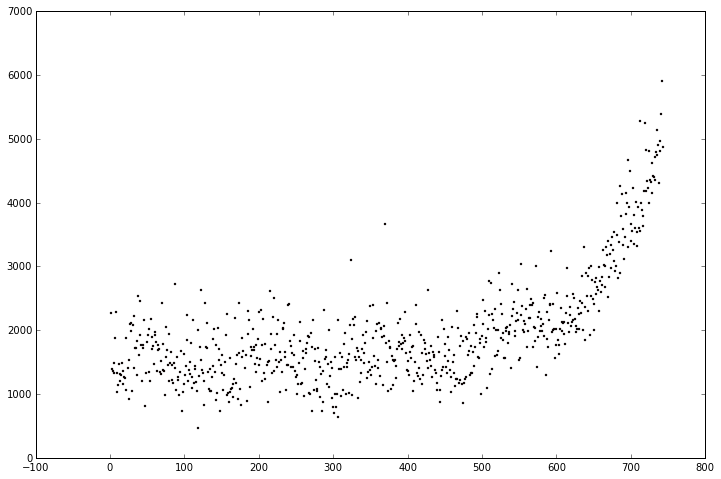

In [14]:
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

plt.scatter(hrs, hits, s=2, c='r')

We can see that starting around hour #600, there is an inflection point where the trend of the data changes.

So there are 2 distrinct trends - one upto hour # 600, and another after hour # 600.

It's also reasonable to assume that the 2nd trend will probably predict future trend better.

So we'll split the data after hour # 600 into a training and a test set in 80:20 ratio.
We'll create multiple models with different degrees and train them on the training set.
We'll then run each model on the test set, and compare their squared errors.

In [40]:
split_data = data_clean[600:]
print split_data.shape[0]
train_len = int(split_data.shape[0] * 0.8)

train_hrs = hrs[600:600+train_len]
train_hits = hits[600:600+train_len]

test_hrs = hrs[600+train_len:]
test_hits = hits[600+train_len:]

print train_len, train_hrs.shape, test_hrs.shape

135
108 (108,) (27,)


7113229.51624
4167106.21604
24437355.3351
94305167.2707
67068884.3195
27155948.8483


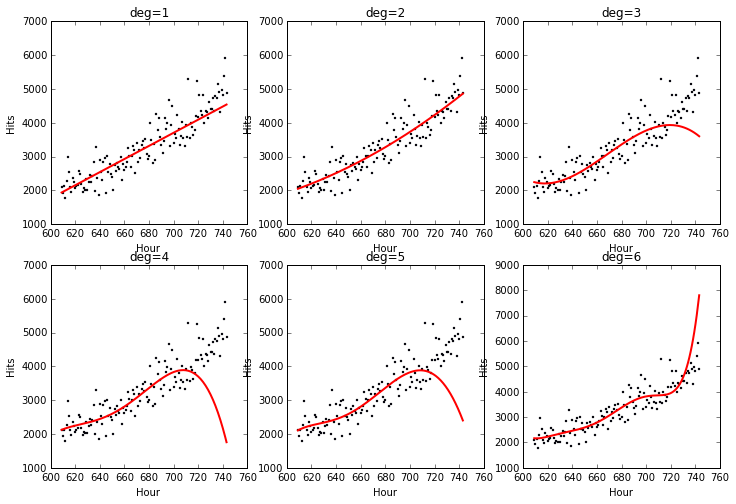

In [55]:
def squared_error(x, y_actual, y_pred):
    return sp.sum((y_pred - y_actual) ** 2)

errors = []
coeffs_list = []
for deg in xrange(1,7):
    coeffs = sp.polyfit(train_hrs, train_hits, deg)
    coeffs_list.append(coeffs)
    f = sp.poly1d(coeffs)
    predicted_test_hits = f(test_hrs)
    err = squared_error(test_hrs, test_hits, predicted_test_hits)
    errors.append(err)
    print err
    predicted_hits = f(split_data[:,0])
    
    plt.subplot(2, 3, deg)
    plt.xlabel('Hour')
    plt.ylabel('Hits')
    plt.title('deg=%d' % (deg))
    plt.scatter(split_data[:,0], split_data[:,1], s=2)
    plt.plot(split_data[:,0], predicted_hits, 'r', lw=2)

We can see from the plots that the 2nd degree polynomial not only has the least squared error but also fits the post-inflection portion of the dataset well, including the preidctions for the test set.

The 1st degree polynomial too does well, but has higher error than the 2nd degree one.

In sharp contrast, all the 3rd and >3rd degree polynomials perform very badly. Their errors are too high, and their predictions are completely wrong. They have **overfitted** the training data.

**Conclusion:** The 2nd degree polynomial is the selected model.

In [57]:
selected_f = sp.poly1d(coeffs_list[1])
print selected_f

         2
0.05835 x - 57.9 x + 1.567e+04


# Using the model to answer questions about the future

Let's assume this analysis was being done to predict when hits would reach a threshold value of 100000/hour, at which point we have decided to upgrade or add new hardware to handle the traffic.

Now that we have modelled the trend, we want to know at what hour the value of hits will become 100000. That is, given y, we want x. We want scipy to solve the equation:

$$0.05835 x^2 - 57.9 x + 15670 = 100000$$

Scipy can solve this using the general multidimensional solver [**scipy.optimize.fsolve()**](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) which takes 2 arguments: 

+ The polynomial function to solve, in the form f(x) = 0. In our case, this will be selected_f - 100000.

+ A starting value for x. Since the last hour in dataset is 743, x can't be less than that. So we set starting value to 744.

In [75]:
from scipy.optimize import fsolve

hr_100000 = fsolve(selected_f-100000, x0=hrs[-1]+1)
week_100000 = hr_100000 / (7*24)
print hr_100000, week_100000, selected_f(hr_100000)

[ 1796.66172493] [ 10.69441503] [ 100000.]


So the model predicts that 100000 hits/hour will be reached around the middle of week # 10.

# Conclusions

1. Analyze the data well. Recognize that a single dataset may include different trends in different portions.
Use visualizations on the dataset.


2. Split the dataset into training and test sets, calculate multiple models, and analyze predictions of each model on the *test set*. Ultimately, the quality of a model is characterized by the quality of its predictions.